# Data Loading

In [1]:
# necessary installs and imports
# from https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html

from __future__ import print_function, division

# !python -m pip install --upgrade pip
# !pip install requests

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from io import BytesIO
from PIL import Image
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import requests
import time
import os
import copy

plt.ion()   # interactive mode

In [2]:
# set up data directories
data_dir = 'data'
train_dir = data_dir + '/train'
valid_dir = data_dir + '/val'
test_dir = data_dir + '/test'

In [3]:
# data transformations and normalization
# normalization values taken from ImageNet pre-trained networks

data_transforms = {
    'train': transforms.Compose([
        transforms.RandomHorizontalFlip(),
        transforms.Resize(255),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize((0.485, 0.456, 0.406),(0.229, 0.224, 0.225))
    ]),
    'val': transforms.Compose([
        transforms.Resize(255),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize((0.485, 0.456, 0.406),(0.229, 0.224, 0.225))
    ]),
    'test': transforms.Compose([
        transforms.Resize(255),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize((0.485, 0.456, 0.406),(0.229, 0.224, 0.225))
    ])
}

# following code adapted from https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html
data_subsets = ['train', 'val', 'test']
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x])
                  for x in data_subsets}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4, shuffle=True, num_workers=4)
               for x in data_subsets}
dataset_sizes = {x: len(image_datasets[x]) for x in data_subsets}
class_names = image_datasets['train'].classes
print(class_names)

# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

['fake', 'real']


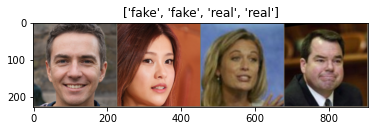

In [4]:
# do some initial visualization
# https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html

def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [5]:
# start with a pre-trained model from torchvision
model = models.densenet161(pretrained=True)
# print out model to find number of inputs for classifier in following step
model.classifier

Downloading: "https://download.pytorch.org/models/densenet161-8d451a50.pth" to /home/ec2-user/.cache/torch/checkpoints/densenet161-8d451a50.pth


  0%|          | 0.00/110M [00:00<?, ?B/s]

Linear(in_features=2208, out_features=1000, bias=True)

In [6]:
# define a new untrained classifier which will serve as final layer in pre-trained network
class NeuralNet(nn.Module):
    def __init__(self):
        super().__init__()

        # try densenet161 with two hidden layers tacked on at the end
        self.fc1 = nn.Linear(2208, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 2)
        
        # define dropout
        self.dropout = nn.Dropout(p=0.2)
        
    def forward(self, x):
        # flatten x here
        x = x.view(x.shape[0], -1)
        
        # perform linear combinations (w/ dropout)
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.dropout(F.relu(self.fc2(x)))

        # remember: output has no dropout
        x = F.log_softmax(self.fc3(x), dim=1)
        
        return x

classifier = NeuralNet()

In [7]:
# replace the pre-trained model's classifier, freezing model params
for param in model.parameters():
    param.requires_grad = False
    
model.classifier = classifier

In [8]:
# set up criterion and optimizer

# because we used log_softmax on our output
criterion = nn.NLLLoss()

# don't mess w/ feature params (from pre-trained model)
# train only the classifier parameters
optimizer = optim.Adam(model.classifier.parameters(), lr=0.002)

In [13]:
## do the training

# move processing to GPU, if possible
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
model.to(device)

# watch my epoch FAIL
epochs = 1

for e in range(epochs):
    train_loss = 0
    for images, labels in dataloaders['train']:
        # move everything to be processed on GPU
        images, labels = images.to(device), labels.to(device)
        
        # feed-forward
        log_p = model(images)
        # calculate loss
        loss = criterion(log_p, labels)
        # back-propogate the loss
        loss.backward()
        # take a gradient-descent step
        optimizer.step()
        
        # keep track of training loss
        train_loss += loss.item()
        
        # zero-out gradients between batches
        optimizer.zero_grad()
    else:
        valid_loss = 0
        accuracy = 0
        with torch.no_grad():
            # turn off dropout for now
            model.eval()
            
            for images, labels in dataloaders['val']:
                # move everything to be processed on GPU, AGAIN
                images, labels = images.to(device), labels.to(device)

                log_p = model(images)
                valid_loss += criterion(log_p, labels)
                
                p = torch.exp(log_p)
                # should get 2 class probs
                # print(p.shape)
                
                # check if predictions were right or not
                _, top_class = p.topk(1, dim=1)
                equals = top_class == labels.view(*top_class.shape)
                accuracy += torch.mean(equals.type(torch.FloatTensor))
    print(f'Epoch: {e+1}/{epochs}')
    print(f'Training loss: {round(train_loss/len(dataloaders["train"]), 3)}')
    print(f'Validation loss: {round(float(valid_loss/len(dataloaders["val"])), 3)}')
    print(f'Validation accuracy: {round(float(100*accuracy/len(dataloaders["val"])), 2)}%')
    print('-----------------------------------------')
            
            
    # turn dropout back on
    model.train()

cpu
Epoch: 1/1
Training loss: 0.004
Validation loss: 0.003
Validation accuracy: 100.0%
-----------------------------------------


In [14]:
# see what accuracy on test images looks like
test_loss = 0
accuracy = 0
model.to(device)
with torch.no_grad():
    # turn off dropout for now
    model.eval()

    for images, labels in dataloaders['test']:
        # move everything to be processed on GPU, AGAIN
        images, labels = images.to(device), labels.to(device)

        # get probability distributions
        p = torch.exp(model(images))

        # check if predictions were right or not
        _, top_class = p.topk(1, dim=1)
        equals = top_class == labels.view(*top_class.shape)
        accuracy += torch.mean(equals.type(torch.FloatTensor))

print(f'Test accuracy: {round(float(100*accuracy/len(dataloaders["test"])), 2)}%')

Test accuracy: 100.0%


In [15]:
# alright, so that worked suprisingly well. let's try this out on some images in the wild

# write a function to prep an image to be fed into the model
def process_image(image):
    ''' Scales, crops, and normalizes a PIL image for a PyTorch model,
        returns an Numpy array
    '''
    # resize image so shortest side is 256, maintaining aspect ratio
    resize_num = 256
    w, h = image.size
    (new_w, new_h) = (1 + (resize_num * w // h), resize_num) if w > h else (resize_num, 1 + (resize_num * h // w))
    resized = image.resize((new_w, new_h))
    
    # crop out center 224x224 pixels
    resized_w, resized_h = resized.size
    w_margin = (resized_w - 224) // 2
    h_margin = (resized_h - 224) // 2
    (left, upper, right, lower) = (w_margin, h_margin, resized_w - w_margin, resized_h - h_margin)
    cropped = resized.crop((left, upper, right, lower))
    
    # convert values from 0-225 to decimals 0-1
    np_image = np.array(cropped)
    np_converted = np_image / 255.0
    
    # normalize via instructions above (hint: look below at provided code in imshow)
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    normalized = (np_converted - mean) / std
    
    # re-order color channels
    reordered = np.transpose(normalized, (2, 0, 1))

    return reordered

In [16]:
# write a function to display an image
def imshow(image, ax=None, title=None):
    """Imshow for Tensor."""
    if ax is None:
        fig, ax = plt.subplots()
    
    # PyTorch tensors assume the color channel is the first dimension
    # but matplotlib assumes is the third dimension
    image = image.numpy().transpose((1, 2, 0))
    
    # Undo preprocessing
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean
    
    # Image needs to be clipped between 0 and 1 or it looks like noise when displayed
    image = np.clip(image, 0, 1)
    
    ax.imshow(image)
    
    return ax

torch.Size([3, 225, 224])


<AxesSubplot:>

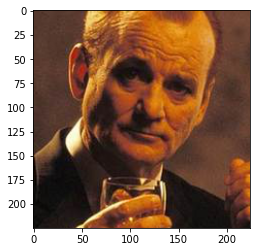

In [26]:
# process and then display an image of a real person from the wild

# remote image opening code from https://stackoverflow.com/a/23489503/1113872
response = requests.get('https://www.fillmurray.com/250/250')
img = Image.open(BytesIO(response.content))

processed = process_image(img)
torched = torch.from_numpy(processed)
print(torched.shape)
imshow(torched)

In [42]:
# ok, now write a function to use the model to do a prediction
def predict(image_path, model, topk=2):
    ''' Predict the class (or classes) of an image using a trained deep learning model.
    '''
#     response = requests.get(image_url)
    processed_img = process_image(Image.open(image_path))
    image = torch.from_numpy(np.expand_dims(processed_img, axis=0))  # to account for batch size

    # target is float32
    image = image.to('cpu')
    image = image.to(dtype=torch.float32)
    model.to('cpu')
    p = torch.exp(model(image))
    probs, cls_idx = p.topk(topk, sorted=True)
    
    idx_to_classes = {0: 'fake', 1: 'real'}
    
    return probs.detach().numpy()[0], [idx_to_classes[c] for c in cls_idx.detach().numpy()[0]]

In [46]:
# now test a few images from the wild
fill_murray_image = f'{data_dir}/real_murray.jpg'
fake_person_image = f'{data_dir}/fake1.jpg'
# so far, so good

# uh-oh, close up images of real people
close_up_real_person_image = f'{data_dir}/close-up-real.jpg'
close_up_ryan_image = f'{data_dir}/real-ryan.jpg'

test_img_path = close_up_real_person_image
probs, classes = predict(test_img_path, model)

print(probs)
print(classes)

[9.9999893e-01 1.0718594e-06]
['fake', 'real']
